In [15]:
import numpy as np 
import scipy.sparse as sps 
import pymrm as mrm 
import matplotlib.pyplot as plt 
from IPython.display import clear_output, display


# 2D Model
class axially_dispersed_plug_flow_reactor: 
    def __init__ (self):
        ##Reactor constants
        self.v = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.u_g = self.v[0]
        self.L = 3
        self.D = 1
        self.H_r = 42e3 #Heat of reaction at (293 K)
        self.eps_b = 0.4 #Bed porosity
        
        ##Gas constants
        self.Rho_g = 1  #Densty of the gas
        self.eta_g = 4e-5 
        self.Cp_g = 5e3 #Heat capacity gas

        ## Maxwell-Stefan constants
        #Moleculaire weight 
        self.M_CO2 = 44  # 1 
        self.M_H2 = 2    # 2
        self.M_CO = 28   # 3
        self.M_H2O = 48  # 4

        #Diffusion volumes
        self.V_CO2 = 26.7 
        self.V_H2 = 6.12
        self.V_CO = 18.0
        self.V_H2O = 13.1

        #Heat capacities
        self.Cp_CO2 = 1.2e3 
        self.Cp_H2 = 15e3
        self.Cp_CO = 1.1e3
        self.Cp_H2O = 2e3

         ## Calculate the average diffusion coefficient for each molecule
        self.Tin = 700
        self.P = 1*101325 
        self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O = self.calculate_average_diffusion_coefficients()  #Moleculare diffsion coeffcients
        self.lam_g = 0.03 #Thermal diffusivity (WHICH COMPONENT)
        self.Rg = 8.314  #Gas constant

        ##Catalyst constants
        self.d_p = 1e-4 #Diameter of the particle 
        self.Cp_s = 0.45e3 #Heat capacity gas (air)
        self.R_e = 1e-7 ## Electric conductivity Iron
        self.I = 2500000 # 1000000 # 
        print(self.R_e*self.I)
        self.Q_joule = 8e4 # self.R_e*self.I**2 # Joule heatign term 
        self.Dax_s = 0.0
        self.lam_s = 70 #Thermal diffusivity
        self.a_gs = 6/self.d_p*(1-self.eps_b) #Specific surface area
        self.rho_s = 4580 #Solid density
        
        # Dimensionless numbers:
        self.Re = self.Rho_g*self.u_g*self.d_p/self.eta_g # Reynolds number [-]
        self.Pr = self.Cp_g*self.eta_g/self.lam_g # Prandtl number [-]
        self.Sc_CO2 = self.eta_g / (self.Rho_g * self.Dm_CO2) # Schmidt number CO2 [-]
        self.Sc_H2 = self.eta_g / (self.Rho_g * self.Dm_H2) # Schmidt number H2 [-]
        self.Sc_CO = self.eta_g / (self.Rho_g * self.Dm_CO) # Schmidt number CO [-]
        self.Sc_H2O = self.eta_g / (self.Rho_g * self.Dm_H2O) # Schmidt number H2O [-]
        
        # Correlations:
        ## Axial mass dispersion
        self.D_ax_g = np.mean([self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O])/np.sqrt(2) + 0.5*self.u_g*self.d_p # Dispersion coefficient gas [m2/s]

        ## Axial thermal dispersion
        self.A = self.lam_s/self.lam_g
        self.B = 1.25*((1-self.eps_b)/self.eps_b)**(10/9)
        self.gamma = 2/(1-self.B/self.A)*((self.A-1)/(1-self.B/self.A)**2*self.B/self.A*(np.log(self.A/self.B))-0.5*(self.B+1))
        self.lam_stat = self.lam_g*((1-np.sqrt(1-self.eps_b))+np.sqrt(1-self.eps_b)*self.gamma)
        self.Df_therm = self.lam_g/self.Rho_g/self.Cp_g
        self.Dax_therm = 0.5*self.Re*self.Pr             ##Dispersion coefficient temperature
      
        self.h_w = self.lam_g/self.d_p*(1.3+5/self.D/self.d_p)*self.lam_stat/self.lam_s+0.19*self.Re**(0.75)*self.Pr**(1/3) ##Bed to wall heat transfer 
        
        # Gas solid mass and heat transfer coefficient    
        self.k_gs_CO2 = self.calculate_mass_transfer_coefficient(self.Dm_CO2, self.Sc_CO2)
        self.k_gs_H2 = self.calculate_mass_transfer_coefficient(self.Dm_H2, self.Sc_H2)
        self.k_gs_CO = self.calculate_mass_transfer_coefficient(self.Dm_CO, self.Sc_CO)
        self.k_gs_H2O = self.calculate_mass_transfer_coefficient(self.Dm_H2O, self.Sc_H2O)
        
        self.h_mt = self.lam_g/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Pr**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Pr**0.33) # Gunn correlations
        
        self.k_mt = np.array([self.k_gs_CO2, self.k_gs_H2, self.k_gs_CO, self.k_gs_H2O, self.h_mt])

        ## Correlations
        self.Dax_g = np.mean([self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O]) * (1/np.sqrt(2)) + 0.5*self.v[0]*self.d_p ## Dispersion coefficient gas
        self.Drad_g = np.mean([self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O]) * (1/np.sqrt(2)) + 0.5*self.v[0]*self.d_p ## Dispersion coefficient gas



        """ ASSUMPTIONS TO BE CHECKED """
        self.Dax_s = 0
        self.Drad_s = self.Drad_g
        self.Drad_therm = self.Df_therm # 0.5*self.Re*self.Pr             ##Dispersion coefficient temperature

        #Gas solid mass transfer coefficient    
        #self.k_mt = self.Dm/self.d_p*(2+0.06*self.Re**(0.5)*self.Sc**(1/3)) #Ranz-Marshall corelation
        #self.k_mt = self.Dm/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Sc**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Sc**0.33)

        #Gas solid heat transfer coeffcient
        #self.h_mt = self.lam_g/self.d_p*(2+0.06*self.Re**(0.5)*self.Pr**(1/3)) #Ranz-Marshall corelation
        #self.h_mt = self.lam_g/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Pr**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Pr**0.33) # Gunn correaltions

        ## Simulation parameters
        self.nz = 200
        self.nr = 10
        self.nc = 8
        self.nT = 2
        self.dt = np.inf
        self.Tin = 700
        self.Tw = 298
        self.P = 1*101325 
        self.X_H2 = 0.5
        self.X_CO2 = 0.5
        self.Cin_H2 = self.P*self.X_H2/(self.Rg*self.Tin)
        self.Cin_CO2 = self.P*self.X_CO2/(self.Rg*self.Tin)
    
        self.z_f= np.linspace(0, self.L, self.nz +1)
        self.z_c = 0.5*(self.z_f[0:-1]+ self.z_f[1:])

        self.r_f = np.linspace(0, self.D/2, self.nr+1)
        self.r_c = 0.5 * (self.r_f[0:-1] + self.r_f[1:])

        self.c0 = np.array([0.0, 0.0, 0.0, 0.0, self.Tin, 0, 0, 0, 0, self.Tin], dtype='float')
        self.cin = np.array([self.Cin_CO2, self.Cin_H2, 0.0, 0.0, self.Tin, 0.0, 0, 0, 0, 0], dtype='float')

        self.Dax = np.array([self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_therm, 0,0,0,0,0], dtype = 'float')
        
        # self.c0 = np.array([0.0, 0.0, 0.0, 0.0, self.Tin, 0, 0, 0, 0, self.Tin], dtype='float')
        # self.cin = np.array([self.Cin_CO2, self.Cin_H2, 0.0, 0.0, self.Tin, 0.0, 0, 0, 0, 0], dtype='float')
        # self.bc_ax = {
        #     'a': [0.0 , 1],
        #     'b': [1.0, 0],
        #     'd': [[[self.cin]] , 0.0]
        # }## C=Cin at Z=0 and zero gradient at Z=L
        
        self.bc_ax = {
            'a': [[[self.Dax]], 1],
            'b': [[[self.v]], 0],
            'd': [[[self.v*self.cin]] , 0.0]
        }## C=Cin at Z=0 and zero gradient at Z=L
       

        self.bc_rad = {
            'a': [1, [[[1, 1, 1, 1, 0,       1, 1, 1, 1, 0]]]],
            'b': [0, [[[0, 0, 0, 0, 1,         0, 0, 0, 0, 1]]]],
            'd': [0, [[[0, 0, 0, 0, self.Tw, 0, 0, 0, 0, self.Tw]]]] 
        } ## Boundry condtion wall T

        self.init_field(self.c0)

        self.init_Jac()

        self.freq_out=100

    def calculate_average_diffusion_coefficients(self):
        # Define the molecules and their properties
        molecules = [
            ('CO2', self.M_CO2, self.V_CO2),
            ('H2', self.M_H2, self.V_H2),
            ('CO', self.M_CO, self.V_CO),
            ('H2O', self.M_H2O, self.V_H2O)
        ]
        
        # Calculate diffusion coefficients for each molecule with every other molecule
        diffusion_coeffs = {mol[0]: [] for mol in molecules}
        
        for i, (name1, M1, V1) in enumerate(molecules):
            for j, (name2, M2, V2) in enumerate(molecules):
                if i != j:
                    diffusion_coeff = self.fuller(self.Tin, M1, M2, V1, V2, self.P)
                    diffusion_coeffs[name1].append(diffusion_coeff)
        
        # Calculate average diffusion coefficient for each molecule
        avg_diffusion_coeffs = {name: np.mean(coeffs) for name, coeffs in diffusion_coeffs.items()}
        print(f"Average Diffusion Coefficients: {avg_diffusion_coeffs}")
        
        return avg_diffusion_coeffs['CO2'], avg_diffusion_coeffs['H2'], avg_diffusion_coeffs['CO'], avg_diffusion_coeffs['H2O']
    
    
    def fuller(self, T, M1, M2, V1, V2, P):
        D_ij = 1.013e-2 * T**1.75 / P * np.sqrt(1/M1 + 1/M2) / (V1**(1/3) + V2**(1/3))**2
        return D_ij


    def calculate_mass_transfer_coefficient(self, D_i, Sc_i):
        # Gunn correlation:
        k_mt = D_i/self.d_p*((7 - 10*self.eps_b + 5*self.eps_b**2)*(1 + 0.7*self.Re**0.2 * Sc_i**0.33) + (1.33 - 2.4*self.eps_b + 1.2*self.eps_b**2)*self.Re**0.7*Sc_i**0.33)
        return k_mt

    def init_field(self, c0):
        self.c = np.full([self.nz, self.nr, self.nc+self.nT], c0, dtype='float')
 
    def reaction(self, c): 
        T_p = c[:,:,9]
        T_f = c[:,:,4]

        #Reaction rate constants
        K_H2O = 96808*np.exp(-51979/(self.Rg*T_p))
        k = 11101.2*np.exp(-117432/(self.Rg*T_p))
        Ke = np.exp(-(-12.11+5319*T_p**(-1)+1.012*np.log(T_p)+1.144*10**(-4*T_p)))

        #Pressure calculation
        Pco2 = c[:,:,5]*self.Rg*T_p
        Ph2 = c[:,:,6]*self.Rg*T_p
        Pco = c[:,:,7]*self.Rg*T_p
        Ph2o = c[:,:,8]*self.Rg*T_p

        f = np.zeros_like(c)
        
        #Reaction rate equation
        r = k*(Pco2*Ph2-(Pco*Ph2o)/(Ke))/(Ph2+K_H2O*Ph2o)*self.rho_s*(1-self.eps_b)*1e3/101325

        r[np.isnan(r)]=0
        # r[np.isinf(r)]=0
        # Source/Sinks terms
        f[:,:,0]= -self.k_mt[0]*self.a_gs*(c[:,:,0]-c[:,:,5])   #-r1+r_1
        f[:,:,1] = -self.k_mt[1]*self.a_gs*(c[:,:,1]-c[:,:,6])   # r1-r2-r_1
        f[:,:,2] =  -self.k_mt[2]*self.a_gs*(c[:,:,2]-c[:,:,7])  #r2
        f[:,:,3] =  -self.k_mt[3]*self.a_gs*(c[:,:,3]-c[:,:,8])
        f[:,:,4] =  self.h_mt*self.a_gs*(T_p-T_f)/(self.Rho_g*self.Cp_g)    
        
        f[:,:,5]= self.k_mt[0]*self.a_gs*(c[:,:,0]-c[:,:,5]) -r   #-r1+r_1
        f[:,:,6] = self.k_mt[1]*self.a_gs*(c[:,:,1]-c[:,:,6]) -r   # r1-r2-r_1
        f[:,:,7] =  self.k_mt[2]*self.a_gs*(c[:,:,2]-c[:,:,7]) +r  #r2
        f[:,:,8] =  self.k_mt[3]*self.a_gs*(c[:,:,3]-c[:,:,8]) +r   
        f[:,:,9] =  -self.h_mt*self.a_gs*(T_p-T_f) -self.H_r*r+self.Q_joule*(1-self.eps_b)

        return f
    

    def init_Jac(self):
        self.Jac_accum = sps.diags([1.0, 1.0, 1.0, 1.0, 1.0, (1-self.eps_b), (1-self.eps_b), (1-self.eps_b), (1-self.eps_b), self.rho_s*self.Cp_s*(1-self.eps_b)]*self.nz*self.nr, dtype='float', format='csc')/self.dt
        Grad, grad_bc = mrm.construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        Conv, conv_bc = mrm.construct_convflux_upwind(self.c.shape, self.z_f, self.z_c, self.bc_ax, self.v, axis=0)
        self.Div_ax = mrm.construct_div(self.c.shape, self.z_f, nu=0, axis=0)
        Dax_m = mrm.construct_coefficient_matrix([[[self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_therm, self.Dax_s, self.Dax_s, self.Dax_s, self.Dax_s, 0]]], self.c.shape, axis=0)
        self.Flux = Conv-Dax_m@Grad
        self.flux_bc = conv_bc -Dax_m@grad_bc
        
        Grad, grad_bc = mrm.construct_grad(self.c.shape, self.r_f, self.r_c, self.bc_rad, axis=1)
        Div_rad = mrm.construct_div(self.c.shape, self.r_f, nu=1, axis=1)
        D_rad_m = mrm.construct_coefficient_matrix([[[self.Drad_g, self.Drad_g, self.Drad_g, self.Drad_g, self.Drad_therm, self.Dax_s, self.Dax_s, self.Dax_s, self.Dax_s, 0]]], self.c.shape, axis=1)
        self.Flux_rad = -D_rad_m @ Grad
        self.flux_rad_bc = -D_rad_m @ grad_bc

        self.g_const = self.Div_ax@self.flux_bc + Div_rad @ self.flux_rad_bc
        self.Jac_const = self.Jac_accum + self.Div_ax@self.Flux + Div_rad @ self.Flux_rad

    def lin_pde(self, c, c_old):
        f_react, Jac_react = mrm.numjac_local(self.reaction, c)
        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, self.z_f, self.z_c, self.bc_ax, self.v, mrm.minmod)
        dg_conv = self.Div_ax@(self.v*dc_f).reshape(-1,1)
        g = self.g_const + self.Jac_const@c.reshape(-1,1) + dg_conv - self.Jac_accum@c_old.reshape(-1,1) -f_react.reshape(-1,1)
        Jac = self.Jac_const-Jac_react 
        return g, Jac 
    

    def solve(self, nt): 
        self.plot_pre()
        for i in range(1,nt+1):
            c_old = self.c.copy()
            result = mrm.newton(lambda c: self.lin_pde(c, c_old), c_old)
            self.c = result.x 
            if (i % self.freq_out == 0):
                self.plot()
        self.plot_temperatures()

    def plot_pre(self):
        self.fig, (self.ax1, self.ax2, self.ax3, self.ax4) = plt.subplots(1, 4, figsize=(25, 5))  # Adjust the figsize as needed
        self.contour1 = self.ax1.pcolormesh(self.r_f, self.z_f, self.c[:, :, 0], shading='flat', cmap='viridis', vmin=0, vmax=9)
        self.contour2 = self.ax2.pcolormesh(self.r_f, self.z_f, self.c[:, :, 1], shading='flat', cmap='viridis', vmin=0, vmax=9)
        self.contour3 = self.ax3.pcolormesh(self.r_f, self.z_f, self.c[:, :, 2], shading='flat', cmap='viridis', vmin=0, vmax=9)
        self.contour4 = self.ax4.pcolormesh(self.r_f, self.z_f, self.c[:, :, 3], shading='flat', cmap='viridis', vmin=0, vmax=9)
        self.fig.colorbar(self.contour1, ax=self.ax1)
        self.fig.colorbar(self.contour2, ax=self.ax2)
        self.fig.colorbar(self.contour3, ax=self.ax3)
        self.fig.colorbar(self.contour4, ax=self.ax4)
        self.ax1.set_xlabel('r')
        self.ax1.set_ylabel('z')
        self.ax1.set_title('CO_2')
        self.ax2.set_xlabel('r')
        self.ax2.set_ylabel('z')
        self.ax2.set_title('H_2')
        self.ax3.set_xlabel('r')
        self.ax3.set_ylabel('z')
        self.ax3.set_title('CO')
        self.ax4.set_xlabel('r')
        self.ax4.set_ylabel('z')
        self.ax4.set_title('H_2O')

    def plot(self):
        clear_output(wait=True)
        self.contour1.set_array(self.c[:, :, 0].flatten())
        self.contour2.set_array(self.c[:, :, 1].flatten())
        self.contour3.set_array(self.c[:, :, 2].flatten())
        self.contour4.set_array(self.c[:, :, 3].flatten())
        display(self.fig)
        plt.show()

    def plot_temperatures(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjust the figsize as needed
        contour1 = ax1.pcolormesh(self.z_f, self.r_f, self.c[:, :, 4].T, shading='auto', cmap='inferno')
        contour2 = ax2.pcolormesh(self.z_f, self.r_f, self.c[:, :, 9].T, shading='auto', cmap='inferno')
        fig.colorbar(contour1, ax=ax1)
        fig.colorbar(contour2, ax=ax2)
        ax1.set_xlabel('z')
        ax1.set_ylabel('r')
        ax1.set_title('Fluid Temperature (T_f)')
        ax2.set_xlabel('z')
        ax2.set_ylabel('r')
        ax2.set_title('Particle Temperature (T_p)')

        plt.show()

# Notebook for 1-D, 2-D and homogeneous model comparison
This notebook compares the results from the 1-D and 2-D heterogeneous model when using the same parameters. The heterogeneous model has been extended to consider Maxwell-Stefan Diffusion and diffusion that depends on the concentration of the components. However, the comparison between the 1-D and 2-D model was done without these extensions. Since the results were different, the 1-D model which matched the verified homogeneous model was chosen.


In [1]:
# 1D Model
class mixed_boundary_heterogeneous: 
    def __init__ (self):
        ##Reactor constants
        self.v = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.u_g = self.v[0]
        self.L = 3
        self.D = 1
        self.H_r = 42e3 #Heat of reaction at (293 K)
        self.eps_b = 0.4 #Bed porosity
        
        ##Gas constants
        self.Rho_g = 1  #Densty of the gas
        self.eta_g = 4e-5 
        self.Cp_g = 5e3 #Heat capacity gas

        ## Maxwell-Stefan constants
        #Moleculaire weight 
        self.M_CO2 = 44  # 1 
        self.M_H2 = 2    # 2
        self.M_CO = 28   # 3
        self.M_H2O = 48  # 4

        #Diffusion volumes
        self.V_CO2 = 26.7 
        self.V_H2 = 6.12
        self.V_CO = 18.0
        self.V_H2O = 13.1

        #Heat capacities
        self.Cp_CO2 = 1.2e3 
        self.Cp_H2 = 15e3
        self.Cp_CO = 1.1e3
        self.Cp_H2O = 2e3

         ## Calculate the average diffusion coefficient for each molecule
        self.Tin = 700
        self.P = 1*101325 
        self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O = self.calculate_average_diffusion_coefficients()  #Moleculare diffsion coeffcients
        self.lam_g = 0.03 #Thermal diffusivity (WHICH COMPONENT)
        self.Rg = 8.314  #Gas constant

        ##Catalyst constants
        self.d_p = 1e-4 #Diameter of the particle 
        self.Cp_s = 0.45e3 #Heat capacity gas (air)
        self.R_e = 1e-7 ## Electric conductivity Iron
        self.I = 2500000 # 1000000 # 
        print(self.R_e*self.I)
        self.Q_joule = 8e4 # self.R_e*self.I**2 # Joule heatign term 
        self.Dax_s = 0.0
        self.lam_s = 70 #Thermal diffusivity
        self.a_gs = 6/self.d_p*(1-self.eps_b) #Specific surface area
        self.rho_s = 4580 #Solid density
        
        # Dimensionless numbers:
        self.Re = self.Rho_g*self.u_g*self.d_p/self.eta_g # Reynolds number [-]
        self.Pr = self.Cp_g*self.eta_g/self.lam_g # Prandtl number [-]
        self.Sc_CO2 = self.eta_g / (self.Rho_g * self.Dm_CO2) # Schmidt number CO2 [-]
        self.Sc_H2 = self.eta_g / (self.Rho_g * self.Dm_H2) # Schmidt number H2 [-]
        self.Sc_CO = self.eta_g / (self.Rho_g * self.Dm_CO) # Schmidt number CO [-]
        self.Sc_H2O = self.eta_g / (self.Rho_g * self.Dm_H2O) # Schmidt number H2O [-]
        
        # Correlations:
        ## Axial mass dispersion
        self.D_ax_g = np.mean([self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O])/np.sqrt(2) + 0.5*self.u_g*self.d_p # Dispersion coefficient gas [m2/s]

        ## Axial thermal dispersion
        self.A = self.lam_s/self.lam_g
        self.B = 1.25*((1-self.eps_b)/self.eps_b)**(10/9)
        self.gamma = 2/(1-self.B/self.A)*((self.A-1)/(1-self.B/self.A)**2*self.B/self.A*(np.log(self.A/self.B))-0.5*(self.B+1))
        self.lam_stat = self.lam_g*((1-np.sqrt(1-self.eps_b))+np.sqrt(1-self.eps_b)*self.gamma)
        self.Df_therm = self.lam_g/self.Rho_g/self.Cp_g
        self.Dax_therm = 0.5*self.Re*self.Pr             ##Dispersion coefficient temperature
        self.h_w = self.lam_g/self.d_p*(1.3+5/self.D/self.d_p)*self.lam_stat/self.lam_s+0.19*self.Re**(0.75)*self.Pr**(1/3) ##Bed to wall heat transfer 
        
        # Gas solid mass and heat transfer coefficient    
        self.k_gs_CO2 = self.calculate_mass_transfer_coefficient(self.Dm_CO2, self.Sc_CO2)
        self.k_gs_H2 = self.calculate_mass_transfer_coefficient(self.Dm_H2, self.Sc_H2)
        self.k_gs_CO = self.calculate_mass_transfer_coefficient(self.Dm_CO, self.Sc_CO)
        self.k_gs_H2O = self.calculate_mass_transfer_coefficient(self.Dm_H2O, self.Sc_H2O)
        
        self.h_mt = self.lam_g/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Pr**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Pr**0.33) # Gunn correlations
        
        self.k_mt = np.array([self.k_gs_CO2, self.k_gs_H2, self.k_gs_CO, self.k_gs_H2O, self.h_mt])

        ## Correlations
        self.Dax_g = np.mean([self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O]) * (1/np.sqrt(2)) + 0.5*self.v[0]*self.d_p ## Dispersion coefficient gas
        self.Drad_g = np.mean([self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O]) * (1/np.sqrt(2)) + 0.5*self.v[0]*self.d_p ## Dispersion coefficient gas

        """ ASSUMPTIONS TO BE CHECKED """
        self.Dax_s = 0
        self.Drad_s = self.Drad_g

        #Gas solid mass transfer coefficient    
        #self.k_mt = self.Dm/self.d_p*(2+0.06*self.Re**(0.5)*self.Sc**(1/3)) #Ranz-Marshall corelation
        #self.k_mt = self.Dm/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Sc**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Sc**0.33)

        #Gas solid heat transfer coeffcient
        #self.h_mt = self.lam_g/self.d_p*(2+0.06*self.Re**(0.5)*self.Pr**(1/3)) #Ranz-Marshall corelation
        #self.h_mt = self.lam_g/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Pr**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Pr**0.33) # Gunn correaltions

        ## Simulation parameters
        self.nz = 200
        self.nr = 0
        self.nc = 8
        self.nT = 2
        self.dt = np.inf
        self.Tin = 700
        self.Tw = 298
        self.P = 1*101325 
        self.X_H2 = 0.5
        self.X_CO2 = 0.5
        self.Cin_H2 = self.P*self.X_H2/(self.Rg*self.Tin)
        self.Cin_CO2 = self.P*self.X_CO2/(self.Rg*self.Tin)
    
        self.z_f= np.linspace(0, self.L, self.nz +1)
        self.z_c = 0.5*(self.z_f[0:-1]+ self.z_f[1:])

        # self.r_f = np.linspace(0, self.D/2, self.nr+1)
        # self.r_c = 0.5 * (self.r_f[0:-1] + self.r_f[1:])

        self.c0 = np.array([0.0, 0.0, 0.0, 0.0, self.Tin, 0, 0, 0, 0, self.Tin], dtype='float')
        self.cin = np.array([self.Cin_CO2, self.Cin_H2, 0.0, 0.0, self.Tin, 0.0, 0, 0, 0, 0], dtype='float')

        self.Dax = np.array([self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_therm, 0,0,0,0,0], dtype = 'float')
        
        # self.c0 = np.array([0.0, 0.0, 0.0, 0.0, self.Tin, 0, 0, 0, 0, self.Tin], dtype='float')
        # self.cin = np.array([self.Cin_CO2, self.Cin_H2, 0.0, 0.0, self.Tin, 0.0, 0, 0, 0, 0], dtype='float')
        # self.bc_ax = {
        #     'a': [0.0 , 1],
        #     'b': [1.0, 0],
        #     'd': [[[self.cin]] , 0.0]
        # }## C=Cin at Z=0 and zero gradient at Z=L
        
        self.bc_ax = {
            'a': [[[self.Dax]], 1],
            'b': [[[self.v]], 0],
            'd': [[[self.v*self.cin]] , 0.0]
        }## C=Cin at Z=0 and zero gradient at Z=L
       

        # self.bc_rad = {
        #     'a': [1, [[[1, 1, 1, 1, 0,       1, 1, 1, 1, 1]]]],
        #     'b': [0, [[[0, 0, 0, 0, 1,         0, 0, 0, 0, 0]]]],
        #     'd': [0, [[[0, 0, 0, 0, self.Tw, 0, 0, 0, 0, self.Tw]]]] 
        # } ## Boundry condtion wall T

        self.init_field(self.c0)

        self.init_Jac()

        self.freq_out=100

    def calculate_average_diffusion_coefficients(self):
        # Define the molecules and their properties
        molecules = [
            ('CO2', self.M_CO2, self.V_CO2),
            ('H2', self.M_H2, self.V_H2),
            ('CO', self.M_CO, self.V_CO),
            ('H2O', self.M_H2O, self.V_H2O)
        ]
        
        # Calculate diffusion coefficients for each molecule with every other molecule
        diffusion_coeffs = {mol[0]: [] for mol in molecules}
        
        for i, (name1, M1, V1) in enumerate(molecules):
            for j, (name2, M2, V2) in enumerate(molecules):
                if i != j:
                    diffusion_coeff = self.fuller(self.Tin, M1, M2, V1, V2, self.P)
                    diffusion_coeffs[name1].append(diffusion_coeff)
        
        # Calculate average diffusion coefficient for each molecule
        avg_diffusion_coeffs = {name: np.mean(coeffs) for name, coeffs in diffusion_coeffs.items()}
        print(f"Average Diffusion Coefficients: {avg_diffusion_coeffs}")
        
        return avg_diffusion_coeffs['CO2'], avg_diffusion_coeffs['H2'], avg_diffusion_coeffs['CO'], avg_diffusion_coeffs['H2O']
    
    
    def fuller(self, T, M1, M2, V1, V2, P):
        D_ij = 1.013e-2 * T**1.75 / P * np.sqrt(1/M1 + 1/M2) / (V1**(1/3) + V2**(1/3))**2
        return D_ij


    def calculate_mass_transfer_coefficient(self, D_i, Sc_i):
        # Gunn correlation:
        k_mt = D_i/self.d_p*((7 - 10*self.eps_b + 5*self.eps_b**2)*(1 + 0.7*self.Re**0.2 * Sc_i**0.33) + (1.33 - 2.4*self.eps_b + 1.2*self.eps_b**2)*self.Re**0.7*Sc_i**0.33)
        return k_mt

    def init_field(self, c0):
        self.c = np.full([self.nz, self.nc+self.nT], c0, dtype='float')
 
    def reaction(self, c): 
        T_p = c[:,9]
        T_f = c[:,4]

        #Reaction rate constants
        K_H2O = 96808*np.exp(-51979/(self.Rg*T_p))
        k = 11101.2*np.exp(-117432/(self.Rg*T_p))
        Ke = np.exp(-(-12.11+5319*T_p**(-1)+1.012*np.log(T_p)+1.144*10**(-4*T_p)))

        #Pressure calculation
        Pco2 = c[:,5]*self.Rg*T_p
        Ph2 = c[:,6]*self.Rg*T_p
        Pco = c[:,7]*self.Rg*T_p
        Ph2o = c[:,8]*self.Rg*T_p

        f = np.zeros_like(c)
        
        #Reaction rate equation
        r = k*(Pco2*Ph2-(Pco*Ph2o)/(Ke))/(Ph2+K_H2O*Ph2o)*self.rho_s*(1-self.eps_b)*1e3/101325

        r[np.isnan(r)]=0
        # r[np.isinf(r)]=0
        # Source/Sinks terms
        f[:,0]= -self.k_mt[0]*self.a_gs*(c[:,0]-c[:,5])   #-r1+r_1
        f[:,1] = -self.k_mt[1]*self.a_gs*(c[:,1]-c[:,6])   # r1-r2-r_1
        f[:,2] =  -self.k_mt[2]*self.a_gs*(c[:,2]-c[:,7])  #r2
        f[:,3] =  -self.k_mt[3]*self.a_gs*(c[:,3]-c[:,8])
        f[:,4] =  self.h_mt*self.a_gs*(T_p-T_f)/(self.Rho_g*self.Cp_g)    
        
        f[:,5]= self.k_mt[0]*self.a_gs*(c[:,0]-c[:,5]) -r   #-r1+r_1
        f[:,6] = self.k_mt[1]*self.a_gs*(c[:,1]-c[:,6]) -r   # r1-r2-r_1
        f[:,7] =  self.k_mt[2]*self.a_gs*(c[:,2]-c[:,7]) +r  #r2
        f[:,8] =  self.k_mt[3]*self.a_gs*(c[:,3]-c[:,8]) +r   
        f[:,9] =  -self.h_mt*self.a_gs*(T_p-T_f) -self.H_r*r+self.Q_joule*(1-self.eps_b)

        return f
    

    def init_Jac(self):
        self.Jac_accum = sps.diags([1.0, 1.0, 1.0, 1.0, 1.0, (1-self.eps_b), (1-self.eps_b), (1-self.eps_b), (1-self.eps_b), self.rho_s*self.Cp_s*(1-self.eps_b)]*self.nz, dtype='float', format='csc')/self.dt
        Grad, grad_bc = mrm.construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        Conv, conv_bc = mrm.construct_convflux_upwind(self.c.shape, self.z_f, self.z_c, self.bc_ax, self.v, axis=0)
        self.Div_ax = mrm.construct_div(self.c.shape, self.z_f, nu=0, axis=0)
        Dax_m = 1 # mrm.construct_coefficient_matrix([[self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_g, 0, self.Dax_s, self.Dax_s, self.Dax_s, self.Dax_s, 0]], self.c.shape)
        self.Flux = Conv- Dax_m*Grad #Dax_m@Grad
        self.flux_bc = conv_bc -  Dax_m*grad_bc #Dax_m@grad_bc
        self.g_const = self.Div_ax@self.flux_bc
        self.Jac_const = self.Jac_accum + self.Div_ax@self.Flux

        # Grad, grad_bc = mrm.construct_grad(self.c.shape, self.r_f, self.r_c, self.bc_rad, axis=1)
        # Div_rad = mrm.construct_div(self.c.shape, self.r_f, nu=1, axis=1)
        # D_rad_m = mrm.construct_coefficient_matrix([[[self.Drad_g, self.Drad_g, self.Drad_g, self.Drad_g, 0, self.Dax_s, self.Dax_s, self.Dax_s, self.Dax_s, 0]]], self.c.shape, axis=1)
        # self.Flux_rad = -D_rad_m @ Grad
        # self.flux_rad_bc = -D_rad_m @ grad_bc

        self.g_const = self.Div_ax@self.flux_bc #+ Div_rad @ self.flux_rad_bc
        self.Jac_const = self.Jac_accum + self.Div_ax@self.Flux # + Div_rad @ self.Flux_rad

    def lin_pde(self, c, c_old):
        f_react, Jac_react = mrm.numjac_local(self.reaction, c)
        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, self.z_f, self.z_c, self.bc_ax, self.v, mrm.minmod)
        dg_conv = self.Div_ax@(self.v*dc_f).reshape(-1,1)
        g = self.g_const + self.Jac_const@c.reshape(-1,1) + dg_conv - self.Jac_accum@c_old.reshape(-1,1) -f_react.reshape(-1,1)
        Jac = self.Jac_const-Jac_react 
        return g, Jac 
    

    def solve(self, nt): 
        self.plot_pre()
        for i in range(1,nt+1):
            c_old = self.c.copy()
            result = mrm.newton(lambda c: self.lin_pde(c, c_old), c_old)
            self.c = result.x 
            if (i % self.freq_out == 0):
                self.plot(nt*self.dt)

    def plot_pre(self):
        plt.ion()
        self.fig1, self.ax1 = plt.subplots(figsize=(10,5))
        self.line1 = []
        labels = ['CO_2', 'H_2', 'CO', 'H_2O']
        for i in range(0, self.nc-4):
            self.line1 += self.ax1.plot(self.z_c, self.c[:,i], label=labels[i])
 
        for i in range(0, self.nc-4):
            self.line1 += self.ax1.plot(self.z_c, self.c[:,i+4], '--', label=labels[i])
        
        self.ax1.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax1.set_xlabel('Position [m]')
        self.ax1.set_ylabel('Concentration [mol/m3]')
        self.ax1.set_xlim(0, self.L)
        self.ax1.set_ylim(0, self.cin[0]*1.2)
        self.ax1.grid()
        self.ax1.legend()

        self.fig2, self.ax2 = plt.subplots(figsize=(10,5))
        self.line2 = []
        
        self.line2 += self.ax2.plot(self.z_c, self.c[:,9], '--', label= 'Solid')
        self.line2 += self.ax2.plot(self.z_c, self.c[:,4], '-', label='Gas')
        
        self.ax2.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax2.set_xlabel('Position [m]')
        self.ax2.set_ylabel('Temperature [k]')
        self.ax2.set_xlim(0, self.L)
        # self.ax2.set_ylim(self.Tin-50, self.Tin)
        self.ax2.grid()
        self.ax2.legend()

    def plot(self, t):
        self.ax1.set_title(f'Time: {t:5.3f} s', fontsize=16)
        for i in range(self.nc-4): 
            self.line1[i].set_ydata(self.c[:,i])
        for i in range(self.nc-4):    
            self.line1[i+4].set_ydata(self.c[:,i+ 4])
        self.fig1.canvas.draw()
        self.fig1.canvas.flush_events()

        self.ax2.set_title(f'Time: {t:5.3f} s', fontsize=16)
        self.line2[0].set_ydata(self.c[:,4])    
        self.line2[1].set_ydata(self.c[:,9])
        self.fig2.canvas.draw()
        self.fig2.canvas.flush_events()


Some aspects which could have influenced the accuracy of the 2-D model include:

1. The small number of grids used in the radial direction. Due to singularity issues, the 2-D solver could not be extended to account for more grids in the radial direction. Because of time limitations and a focus in reactor optimization, this was not looked into.

2. The boundary conditions used for temperature at the wall. A constant wall temperature boundary condition and constant flux was tested to consider heat losses due to ambient temperature. The 1-D heterogeneous and homogeneous models considered a source term for bed to wall heat transfer previously but not in the final script used for optimization. This could be a limitation to the accuracy of the results

In [3]:
# Solve 2D Model
reactor = axially_dispersed_plug_flow_reactor()
solution = reactor.solve(100)

NameError: name 'axially_dispersed_plug_flow_reactor' is not defined

Average Diffusion Coefficients: {'CO2': 0.00014644818536810634, 'H2': 0.00034694037306470023, 'CO': 0.00017219579832493048, 'H2O': 0.00018436441480061143}
0.25


C:\Users\20200955\AppData\Local\Temp\ipykernel_18336\1486580150.py:210: RuntimeWarning: invalid value encountered in divide
  r = k*(Pco2*Ph2-(Pco*Ph2o)/(Ke))/(Ph2+K_H2O*Ph2o)*self.rho_s*(1-self.eps_b)*1e3/101325


1.6666666666666667 0.5 6.666666666666667


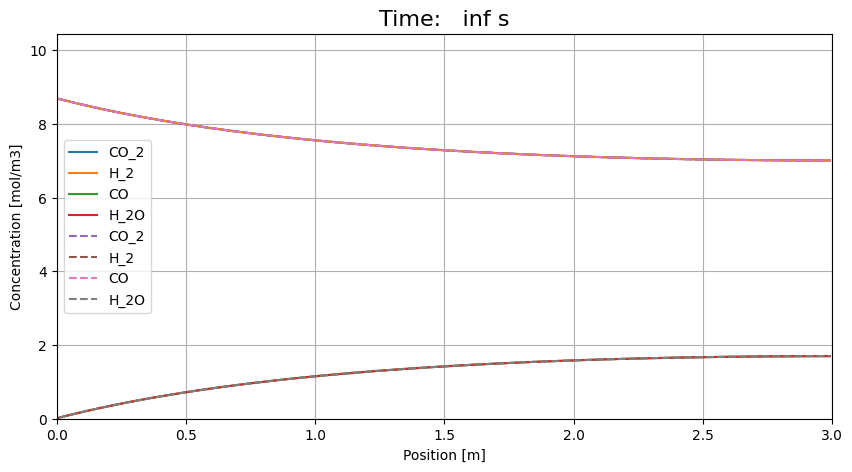

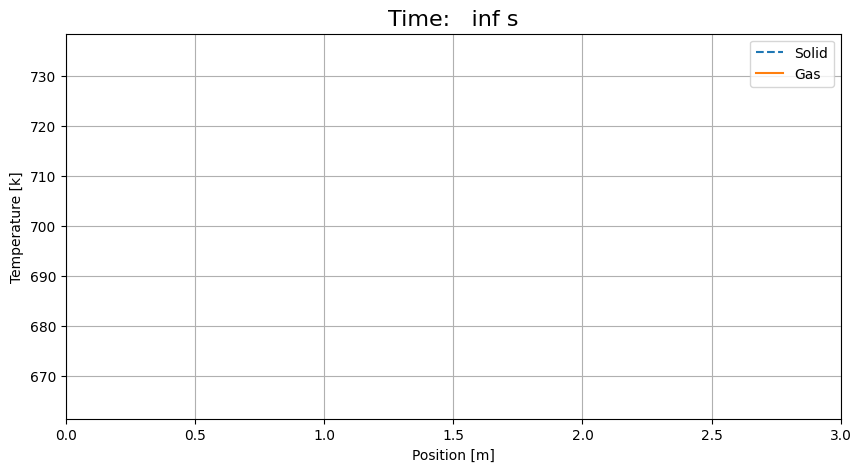

In [ ]:
# Solve 1D Model
heterogeneous_1D = mixed_boundary_heterogeneous()
heterogeneous_1D.solve(100)
array_homogeneous = np.zeros([heterogeneous_1D.nz,2,5])
c = heterogeneous_1D.c
axial_1D = heterogeneous_1D.z_c

print(heterogeneous_1D.Dax_therm,heterogeneous_1D.Re, heterogeneous_1D.Pr)



Average Diffusion Coefficients: {'CO2': 0.00014644818536810634, 'H2': 0.00034694037306470023, 'CO': 0.00017219579832493048, 'H2O': 0.00018436441480061143}


C:\Users\20200955\AppData\Local\Temp\ipykernel_18336\2792956242.py:167: RuntimeWarning: invalid value encountered in divide
  r = k*(Pco2*Ph2-(Pco*Ph2o)/(Ke))/(Ph2+K_H2O*Ph2o)*self.rho_s*(1-self.eps_b)*1e3/101325


8.333333333333334 2.5 6.666666666666667


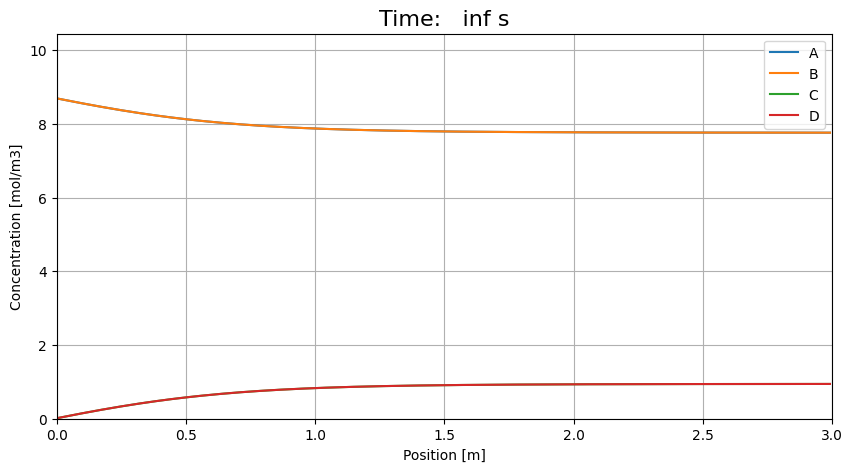

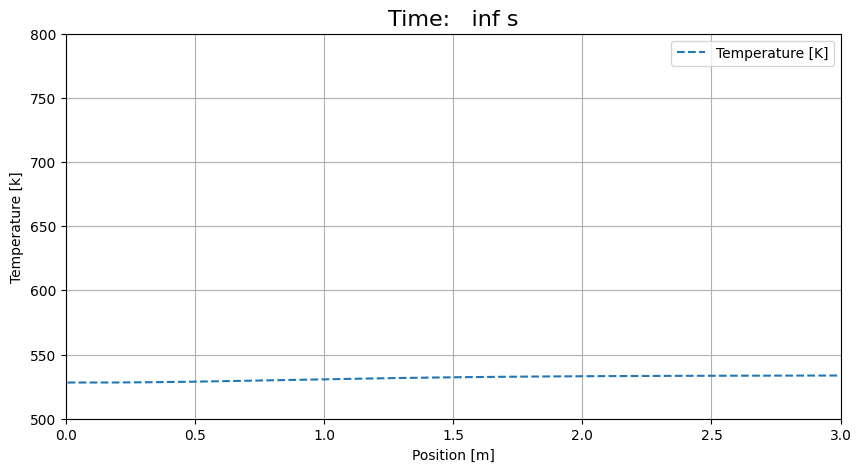

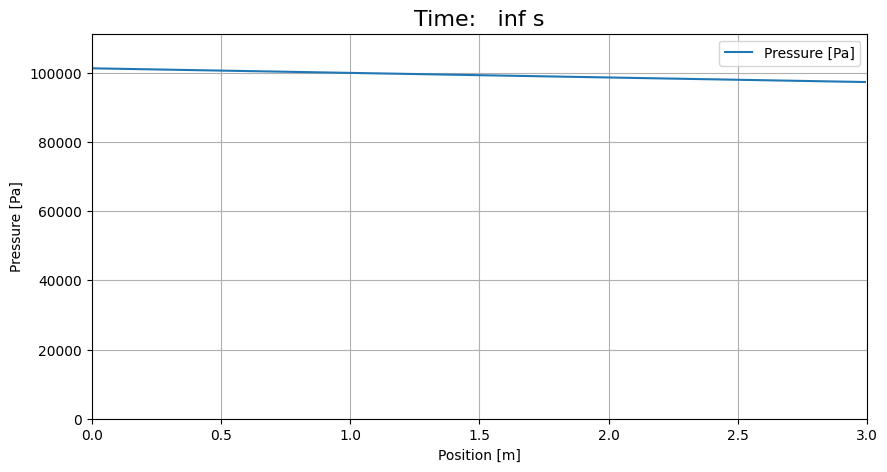

In [ ]:
# Solve the Homogeneous model
class mixed_boundary_homogeneous: 
    def __init__ (self):
        self.Dax = 0.0
        self.v = [0.02,0.02,0.02,0.02,0.02,0.02]
        self.L = 3.0
        self.D = 1.0
        self.d_p = 1e-4
        self.H_r = 42e3 #Heat of reaction at (293 K)
        self.eps_b = 0.4 #Bed porosity
        self.Tw = 298
        
        ## Gas constants
        self.Rho_g = 1  # Density of the gas
        self.eta_g = 4e-5 # Viscosity of the gas 
        self.lam_g = 0.03 # Thermal diffusivity
        self.Rg = 8.314  # Gas constant
        self.Cp_g = 5e3 #Heat capacity gas
        self.Dm = 1e-6  #Moleculare diffsion coeffcient

        ##Catalyst constants
        self.d_p = 5e-3 #Diameter of the particle 
        self.Cp_s = 0.45e3 #Heat capacity gas (air)
        self.Dax_s = 0.0
        self.lam_s = 70 #Thermal diffusivity
        self.a_gs = 6/self.d_p*(1-self.eps_b) #Specific surface area
        self.rho_s = 4580 #Solid density
        self.R_e = 1e-7 ## Electric conductivity Iron
        self.I = 2500000 #1000000 # 2500000
        self.Q_joule = 8e4 # self.R_e*self.I**2 # Joule heating term 

        ##Dimensionless numbers
        self.Re = self.Rho_g*self.v[0]*self.d_p/self.eta_g
        self.Pr = self.Cp_g*self.eta_g/self.lam_g
        self.Sc = self.eta_g/self.Rho_g/self.Dm

        	## Corelations
        self.Dax_g = self.Dm/np.sqrt(2)+0.5*self.v[0]*self.d_p ##Dispersion coeffcient gas
        self.Drad_g = self.Dm/np.sqrt(2)+1/12*self.v[0]*self.d_p
        self.A = self.lam_s/self.lam_g
        self.B = 1.25*((1-self.eps_b)/self.eps_b)**(10/9)
        self.gamma = 2/(1-self.B/self.A)*((self.A-1)/(1-self.B/self.A)**2*self.B/self.A*(np.log(self.A/self.B))-0.5*(self.B+1))
        self.lam_stat = self.lam_g*((1-np.sqrt(1-self.eps_b))+np.sqrt(1-self.eps_b)*self.gamma)

        self.Df_therm = self.lam_g/self.Rho_g/self.Cp_g
        self.Dax_therm = 0.5*self.Re*self.Pr                    ##Dispersion coeffcient temerpature
        self.h_w = self.lam_g/self.d_p*(1.3+5/self.D/self.d_p)*self.lam_stat/self.lam_s+0.19*self.Re**(0.75)*self.Pr**(1/3) ##Bed to wall heat transfer 

        #Gas solid mass transfer coefficient    
        #self.k_mt = self.Dm/self.d_p*(2+0.06*self.Re**(0.5)*self.Sc**(1/3)) #Ranz-Marshall corelation
        self.k_mt = self.Dm/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Sc**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Sc**0.33)

        #Gas solid heat transfer coeffcient
        #self.h_mt = self.lam_g/self.d_p*(2+0.06*self.Re**(0.5)*self.Pr**(1/3)) #Ranz-Marshall corelation
        self.h_mt = self.lam_g/self.d_p*((7-10*self.eps_b+5*self.eps_b**2)*(1+0.7*self.Re**0.2*self.Pr**0.33)+(1.33-2.4*self.eps_b+1.2*self.eps_b**2)*self.Re**0.7*self.Pr**0.33) # Gunn correaltions
        ## Maxwell-Stefan constants
        #Moleculaire weight 
        self.M_CO2 = 44  # 1 
        self.M_H2 = 2    # 2
        self.M_CO = 28   # 3
        self.M_H2O = 48  # 4

        #Diffusion volumes
        self.V_CO2 = 26.7 
        self.V_H2 = 6.12
        self.V_CO = 18.0
        self.V_H2O = 13.1

        #Heat capacities
        self.Cp_CO2 = 1.2e3 
        self.Cp_H2 = 15e3
        self.Cp_CO = 1.1e3
        self.Cp_H2O = 2e3

        ## Calculate the average diffusion coefficient for each molecule
        self.Tin = 700
        self.P = 1*101325 
        self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O = self.calculate_average_diffusion_coefficients(self.Tin, self.P)
        
        ## Correlations
        self.Dax_g = np.mean([self.Dm_CO2, self.Dm_H2, self.Dm_CO, self.Dm_H2O]) * (1/np.sqrt(2)) + 0.5*self.v[0]*self.d_p ## Dispersion coefficient gas
        
        self.nz = 200
        self.nc = 4
        self.nT = 1
        self.nP = 1
        self.dt = np.inf
        self.T = 700
        self.eps_b = 0.4
        self.rho_s = 4580
        self.rho_g = 1
        self.Cp_g = 5e3
        self.Rg = 8.314
        self.X_H2 = 0.5
        self.X_CO2 = 0.5
        self.Cin_H2 = self.P*self.X_H2/(self.Rg*self.T)
        self.Cin_CO2 = self.P*self.X_CO2/(self.Rg*self.T)

        self.H_r = 42e3

        self.z_f= np.linspace(0, self.L, self.nz +1)
        self.z_c = 0.5*(self.z_f[0:-1]+ self.z_f[1:])


        ##Intial concentration otherwise the density can not be calculated
        self.c0 = np.array([0.0, 0.0, 0.0, 0.0, self.T, self.P], dtype='float')
        self.cin = np.array([self.Cin_CO2, self.Cin_H2, 0.0, 0.0, self.T, self.P], dtype='float')
        self.bc_ax = {'a': [0, 1.0], 'b':[1.0, 0.0] , 'd':[[self.cin], 0.0]}
        self.Dax = np.array([self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_therm, 0], dtype = 'float')
        # self.Dax_therm
        
        self.bc_ax = {
            'a': [[[self.Dax]], 1],
            'b': [[[self.v]], 0],
            'd': [[[self.v*self.cin]] , 0.0]
        }## C=Cin at Z=0 and zero gradient at Z=L
    
        self.init_field(self.c0)

        self.init_Jac()

        self.freq_out=1

    def fuller(self, T, M1, M2, V1, V2, P):
        D_ij = 1.013e-2 * T**1.75 / P * np.sqrt(1/M1 + 1/M2) / (V1**(1/3) + V2**(1/3))**2
        return D_ij

    def calculate_average_diffusion_coefficients(self, T, P):
        # Define the molecules and their properties
        molecules = [
            ('CO2', self.M_CO2, self.V_CO2),
            ('H2', self.M_H2, self.V_H2),
            ('CO', self.M_CO, self.V_CO),
            ('H2O', self.M_H2O, self.V_H2O)
        ]
        
        # Calculate diffusion coefficients for each molecule with every other molecule
        diffusion_coeffs = {mol[0]: [] for mol in molecules}
        
        for i, (name1, M1, V1) in enumerate(molecules):
            for j, (name2, M2, V2) in enumerate(molecules):
                if i != j:
                    diffusion_coeff = self.fuller(T, M1, M2, V1, V2, P)
                    diffusion_coeffs[name1].append(diffusion_coeff)
        
        # Calculate average diffusion coefficient for each molecule
        avg_diffusion_coeffs = {name: np.mean(coeffs) for name, coeffs in diffusion_coeffs.items()}
        print(f"Average Diffusion Coefficients: {avg_diffusion_coeffs}")
        
        return avg_diffusion_coeffs['CO2'], avg_diffusion_coeffs['H2'], avg_diffusion_coeffs['CO'], avg_diffusion_coeffs['H2O']

    def init_field(self, c0):
        self.c = np.full([self.nz, self.nc+self.nT+self.nP], c0, dtype='float')

    def reaction(self, c): 
        T = c[:,4]
        K_H2O = 96808*np.exp(-51979/(self.Rg*T))
        k = 11101.2*np.exp(-117432/(self.Rg*T))
        Ke = np.exp(-(-12.11+5319*T**(-1)+1.012*np.log(T)+1.144*10**(-4*T)))
        Pco2 = c[:,0]*self.Rg*T
        Ph2 = c[:,1]*self.Rg*T
        Pco = c[:,2]*self.Rg*T
        Ph2o = c[:,3]*self.Rg*T

        f = np.zeros_like(c)
        
        r = k*(Pco2*Ph2-(Pco*Ph2o)/(Ke))/(Ph2+K_H2O*Ph2o)*self.rho_s*(1-self.eps_b)*1e3/101325
        
        r[np.isnan(r)]=0
        r[np.isinf(r)] = 0

        rho_g = 1 # (c[:,0]*self.M_CO2+c[:,1]*self.M_H2+c[:,2]*self.M_CO+c[:,3]*self.M_H2O)*1e-3
        Cp_g = 5e3 # (c[:,0]*self.Cp_CO2+c[:,1]*self.Cp_H2+c[:,2]*self.Cp_CO+c[:,3]*self.Cp_H2O)/(c[:,0]+c[:,1]+c[:,2]+c[:,3])

        f[:,0]= -r
        f[:,1] = -r
        f[:,2] = +r 
        f[:,3] = +r
        f[:,4] = -self.H_r*r/rho_g/Cp_g + (1-self.eps_b)*self.Q_joule/rho_g/Cp_g - 4*self.h_w/self.D*(T-self.Tw)/self.Rho_g/self.Cp_g   

        ## Ergun equation 
        f[:,5] = -150*self.eta_g*self.v[0]*(1-self.eps_b)**2/(self.d_p**2*self.eps_b**3)+1.75*rho_g*(1-self.eps_b)/(self.d_p*self.eps_b**2)*self.v[0]**2
        
        return f

# (self.eps_b*self.rho_g*self.Cp_g + (1 - self.eps_b)*self.rho_s*self.Cp_s)
#  self.convterm = self.eps_b*self.rho_g*self.Cp_g*self.v[0]
    def init_Jac(self):
        Jac_accum= sps.diags([1.0,1.0,1.0,1.0, 1.0, 0.0]*self.nz, dtype='float', format='csc')/self.dt
        Grad, grad_bc = mrm.construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        Conv, conv_bc = mrm.construct_convflux_upwind(self.c.shape, self.z_f, self.z_c, self.bc_ax, self.v, axis=0)
        self.Div_ax = mrm.construct_div(self.c.shape, self.z_f, nu=0, axis=0)
        self.Dax_m = mrm.construct_coefficient_matrix([[self.Dax_g, self.Dax_g, self.Dax_g, self.Dax_g, 0, 0]], self.c.shape, axis=0)
        self.Flux = Conv-self.Dax_m@Grad
        self.flux_bc = conv_bc -self.Dax_m@grad_bc
        self.g_const = self.Div_ax@self.flux_bc
        self.Jac_const = Jac_accum + self.Div_ax@self.Flux

    def lin_pde(self, c, c_old):
        f_react, Jac_react = mrm.numjac_local(self.reaction, c)
        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, self.z_f, self.z_c, self.bc_ax, self.v, mrm.minmod)
        dg_conv = self.Div_ax@(self.v*dc_f).reshape(-1,1)
        g = self.g_const + self.Jac_const@c.reshape(-1,1) + dg_conv - c_old.reshape(-1,1)/self.dt -f_react.reshape(-1,1)
        Jac = self.Jac_const-Jac_react 

        return g, Jac 
    

    def solve(self, nt): 
        self.plot_pre()
        for i in range(1,nt+1):
            c_old = self.c.copy()
            result = mrm.newton(lambda c: self.lin_pde(c, c_old), c_old)
            self.c = result.x 
            # print(f'X = {self.c[-1,2]/(self.Cin_H2)}')
            if (i% self.freq_out==0):
                self.plot(i*self.dt)

    
    def plot_pre(self):
        plt.ion()
        self.fig1, self.ax1 = plt.subplots(figsize=(10,5))
        self.line1 = []
        for i in range(0, self.nc):
            self.line1 += self.ax1.plot(self.z_c, self.c[:,i], label=chr(ord('A')+i))
 
        self.ax1.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax1.set_xlabel('Position [m]')
        self.ax1.set_ylabel('Concentration [mol/m3]')
        self.ax1.set_xlim(0, self.L)
        self.ax1.set_ylim(0, self.cin[0]*1.2)
        self.ax1.grid()
        self.ax1.legend()

        self.fig2, self.ax2 = plt.subplots(figsize=(10,5))
        self.line2 = []

        self.line2 += self.ax2.plot(self.z_c, self.c[:,-2], '--', label= 'Temperature [K]')
        
        self.ax2.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax2.set_xlabel('Position [m]')
        self.ax2.set_ylabel('Temperature [k]')
        self.ax2.set_xlim(0, self.L)
        self.ax2.set_ylim(self.T-200, self.T+100)
        self.ax2.grid()
        self.ax2.legend()

        self.fig3, self.ax3 = plt.subplots(figsize=(10,5))
        self.line3 = []
    
        self.line3 += self.ax3.plot(self.z_c, self.c[:,-1], '-', label= 'Pressure [Pa]')
        
        self.ax3.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax3.set_xlabel('Position [m]')
        self.ax3.set_ylabel('Pressure [Pa]')
        self.ax3.set_ylim(self.P-101325, self.P+10000)
        self.ax3.set_xlim(0, self.L)
        self.ax3.grid()
        self.ax3.legend()


    def plot(self, t):
        self.ax1.set_title(f'Time: {t:5.3f} s', fontsize=16)
        for i in range(self.nc): 
            self.line1[i].set_ydata(self.c[:,i])
        self.fig1.canvas.draw()
        self.fig1.canvas.flush_events()

        self.ax2.set_title(f'Time: {t:5.3f} s', fontsize=16)
        self.line2[0].set_ydata(self.c[:,-2])    
        self.fig2.canvas.draw()
        self.fig2.canvas.flush_events

        self.ax3.set_title(f'Time: {t:5.3f} s', fontsize=16)
        self.line3[0].set_ydata(self.c[:,-1])    
        self.fig3.canvas.draw()
        self.fig3.canvas.flush_events()

homogeneous = mixed_boundary_homogeneous()
homogeneous.solve(1000)
homogeneous_axial_pos = homogeneous.z_c
homogeneous_values = homogeneous.c
print(homogeneous.Dax_therm,homogeneous.Re,homogeneous.Pr)

[7.17026193 7.17026193 7.17026194 7.17026201 7.17026288 7.1702737
 7.17041088 7.17217182 7.19496754 7.4968752 ]


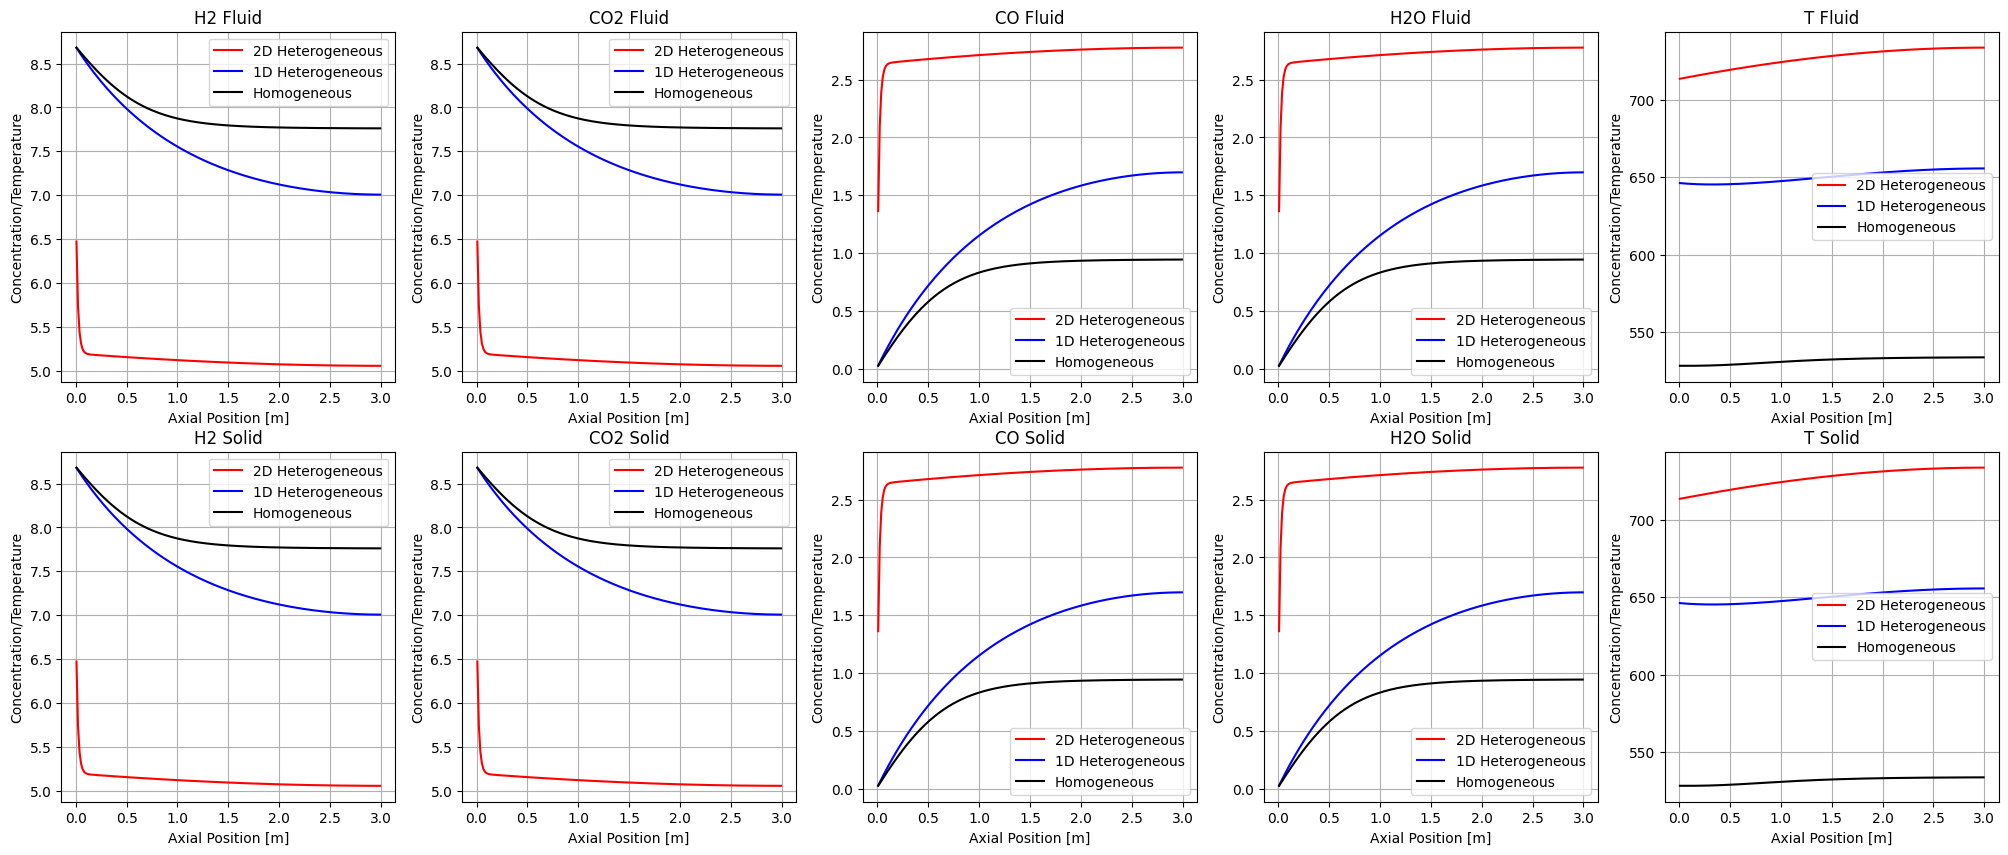

In [ ]:
# NZ 100 NR 10
nc = 4
nt = 1
totn = nc + nt
nphases= 2
pos_r = reactor.r_c
fig, ax = plt.subplots(nphases, totn, figsize=(25, 10))
labels = ['H2 Fluid', 'CO2 Fluid','CO Fluid', 'H2O Fluid', 'T Fluid','H2 Solid', 'CO2 Solid','CO Solid', 'H2O Solid', 'T Solid']
# radially_averaged = np.zeros_like(reactor.z_c)

axial_position = reactor.z_c
# Pre allocate average concentration values
# [Position Component]
# First loop over 10 components
average_array = np.zeros([len(axial_position),2,5])


test = reactor.c[:,:,0]
print(test[0,:])


# nphases = 2
# totn = 5
for i in range(nphases):
    for j in range(totn):
        con_r = reactor.c[:,:,j + i*totn]
        for k in range(len(axial_position)):
            y = con_r[k,:]
            x = pos_r
            dx = 0.0001
            integral = np.trapz(y, x = x, dx = dx) # (con_r[k,:]*pos_r)
            average_array[k,i,j] = integral/(reactor.D/2)

for i in range(nphases):
    for j in range(totn):
        ax[i,j].plot(axial_position,average_array[:,i,j], color = 'red', label = '2D Heterogeneous')
        ax[i,j].plot(axial_1D, c[:,j + totn*i] ,color = 'blue' , label = '1D Heterogeneous')
        ax[i,j].plot(homogeneous_axial_pos, homogeneous_values[:,j], color = 'black' ,label = 'Homogeneous')
        #ax[i,j].plot(axial_position,array_homogeneous[:,i,j], label = 'Homogeneous')
        ax[i,j].set_xlabel('Axial Position [m]')
        ax[i,j].set_ylabel('Concentration/Temperature') 
        ax[i,j].set_title(labels[i*totn + j])    
        ax[i,j].grid()
        ax[i,j].legend()

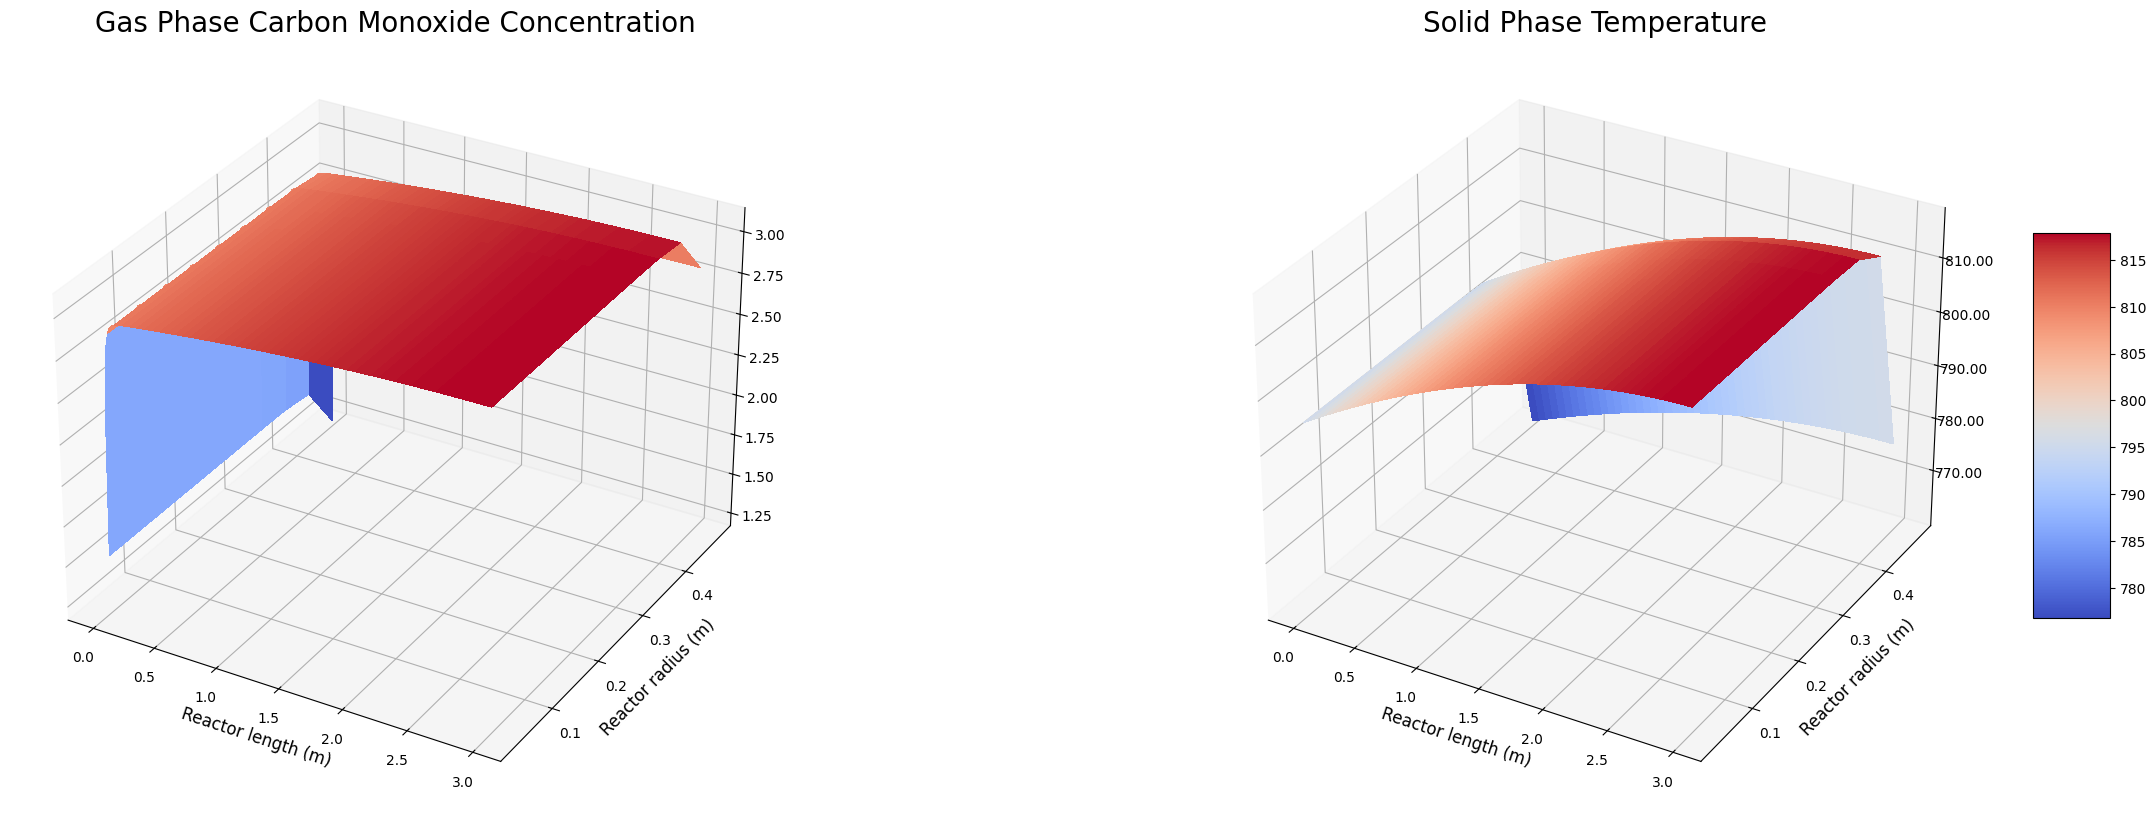

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(1,2, subplot_kw={"projection": "3d"}, figsize=(30, 10))

# Make data.
X = reactor.r_c
Y = reactor.z_c
X, Y = np.meshgrid(X, Y)

# Carbon monoxide concentration which is desired
Z = reactor.c[:,:,3]

# Plot the surface.
surf = ax[0].plot_surface(Y, X, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax[0].zaxis.set_major_formatter('{x:.02f}')
ax[0].set_title('Gas Phase Carbon Monoxide Concentration', fontsize = 20)
ax[0].set_xlabel('Reactor length (m)',fontsize = 12)
ax[0].set_ylabel('Reactor radius (m)',fontsize = 12)



# Carbon monoxide concentration which is desired
Temperature = reactor.c[:,:,9]

# Plot the surface.
surf = ax[1].plot_surface(Y, X, Temperature, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax[1].zaxis.set_major_formatter('{x:.02f}')
ax[1].set_title('Solid Phase Temperature', fontsize = 20)
ax[1].set_xlabel('Reactor length (m)',fontsize = 12)
ax[1].set_ylabel('Reactor radius (m)',fontsize = 12)



# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()